# Import e path

In [1]:
import torch

print(torch.__version__)

models_save_path = "/workspace/RL-for-ViT/Models_mnist/"
results_save_path_agent = "/workspace/RL-for-ViT/Results_mnist/"
dataset_path = "/workspace/RL-for-ViT/Datasets_mnist/"

2.4.1+cu121


In [2]:
# Libraries for data handling
import numpy as np
import pandas as pd

# Libraries for image manipulation and machine learning
import torchvision
import torchvision.transforms as transforms
import torch
import torch.utils.data as data
import torch.nn as nn
from torch.nn import functional
import torch.optim as optim

# Libraries for model evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Libraries for tensor manipulation
from einops import rearrange
from einops.layers.torch import Rearrange

# Libraries for simulation environments (gym)
import gym

# Libraries for data visualization
import matplotlib.pyplot as plt

# Other common libraries
from collections import namedtuple
import math
import time
import os
import random

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu') 
device

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


device(type='cuda', index=3)

In [3]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def posemb_sincos_2d(patches, temperature = 10000, dtype = torch.float32):
    _, h, w, dim, device, dtype = *patches.shape, patches.device, patches.dtype

    y, x = torch.meshgrid(torch.arange(h, device = device), torch.arange(w, device = device), indexing = 'ij')
    assert (dim % 4) == 0, 'feature dimension must be multiple of 4 for sincos emb'
    omega = torch.arange(dim // 4, device = device) / (dim // 4 - 1)
    omega = 1. / (temperature ** omega)

    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim = 1)
    return pe.type(dtype)


In [4]:
# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head),
                FeedForward(dim, mlp_dim)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class SimpleAgentViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64):
        super().__init__()

        self.patches = []

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.to_latent = nn.Identity()
        self.linear_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        *_, h, w, dtype = *img.shape, img.dtype

        x = self.to_patch_embedding(img)
        pe = posemb_sincos_2d(x)
        x = rearrange(x, 'b ... d -> b (...) d') + pe

        # Masking the input based on selected patches
        mask = torch.tensor(self.patches, dtype=torch.bool)
        x = x[:, mask, :]

        x = self.transformer(x)

        x = x.mean(dim = 1)

        x = self.to_latent(x)
        return self.linear_head(x)

    def set_patches(self, patch):
        mean = torch.mean(patch)
        selected = [0 if elem < mean else 1 for elem in patch]
        self.patches = selected

    def get_patches(self):
        return self.patches

    def get_att(self, img):
        *_, h, w, dtype = *img.shape, img.dtype

        x = self.to_patch_embedding(img)
        pe = posemb_sincos_2d(x)
        x = rearrange(x, 'b ... d -> b (...) d') + pe

        attn, ff = self.transformer.layers[0]
        x = attn(x)
        x = torch.mean(x, dim=2)
        return x


In [5]:
batch_size = 128
img_size = 28
dataset_name = "MNIST_BIG_"

transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.Resize(img_size),
    # transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

transform_validation = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])


In [6]:
# Prepare/download dataset
trainset = torchvision.datasets.MNIST(root=dataset_path, train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

validationset = torchvision.datasets.MNIST(root=dataset_path, train=False, download=True, transform=transform_validation)

dataset_size = len(validationset)
validation_size = int(0.95 * dataset_size)
test_size = dataset_size - validation_size

validationset, testset = data.random_split(validationset, [validation_size, test_size])

validation_loader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = trainset.classes
print(classes)


['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [7]:
def train_iter_agent(model, optimizer, data, target):
    start_time = time.time()

    model.train()

    optimizer.zero_grad()
    out = functional.log_softmax(model(data), dim=1)
    loss = functional.nll_loss(out, target)
    loss.backward()
    optimizer.step()

    iteration_time = time.time() - start_time

    return loss.item(), iteration_time

# def evaluate_agent(model, data_load, device):

#     patches = model.get_patches()
#     model.set_patches(torch.tensor([1 for i in range(len(patches))], dtype=torch.float))
#     model.eval()


#     elements = 0
#     csamp = 0
#     tloss = 0

#     with torch.no_grad():
#         for data, target in data_load:

#             elements += len(data)
#             data = data.to(device)
#             target = target.to(device)

#             output = functional.log_softmax(model(data), dim=1)
#             loss = functional.nll_loss(output, target, reduction='sum')
#             _, pred = torch.max(output, dim=1)

#             tloss += loss.item()
#             csamp += pred.eq(target).sum()

#     loss_val = tloss / elements
#     acc_val = (100.0 * csamp / elements).cpu()

#     print('\nAverage test loss: ' + '{:.4f}'.format(loss_val) +
#           '  Accuracy:' + '{:5}'.format(csamp) + '/' +
#           '{:5}'.format(elements) + ' (' +
#           '{:4.2f}'.format(acc_val) + '%)\n')

#     model.set_patches(patches)

#     return loss_val, acc_val

# def evaluate_agent(model, data_load, device, mode=False):

#     model.eval()
#     elements = 0
#     csamp = 0
#     tloss = 0

#     with torch.no_grad():
#         for data, target in data_load:
#             data = data.to(device)
#             target = target.to(device)

#             # mode에 따라 patch mask 선택 방식 다르게
#             if mode == "agent":
#                 # agent가 선택한 패치를 적용
#                 state = env.get_state(data)
#                 action = trainer.agent.select_action(state)
#                 model.set_patches(action)

#             elif mode == "random":
#                 # 랜덤 마스크
#                 action = env.action_space.sample()
#                 model.set_patches(action)

#             else:
#                 # 모든 패치 사용
#                 full_mask = torch.ones(len(model.get_patches()), dtype=torch.float32)
#                 model.set_patches(full_mask)

#             output = functional.log_softmax(model(data), dim=1)
#             loss = functional.nll_loss(output, target, reduction='sum')
#             _, pred = torch.max(output, dim=1)

#             tloss += loss.item()
#             csamp += pred.eq(target).sum()
#             elements += len(data)

#     loss_val = tloss / elements
#     acc_val = (100.0 * csamp / elements).cpu()

#     print(f"\nEval Mode: {mode}, Acc: {acc_val:.2f}%")

#     return loss_val, acc_val

def evaluate_agent(model, agent, data_load, device, mode=None):
    model.eval()

    elements = 0
    csamp = 0
    tloss = 0

    with torch.no_grad():
        for data, target in data_load:
            elements += len(data)
            data = data.to(device)
            target = target.to(device)

            # --- 패치 선택 모드 ---
            if mode == "agent":
                state = agent.env.get_state(data)
                action = agent.select_action(state, eps=0.0)   # greedy 선택
            elif mode == "random":
                action = agent.env.action_space.sample()
            else:
                # 모든 패치 사용
                action = torch.ones(len(agent.env.action_space.sample()), dtype=torch.float32)

            model.set_patches(action)

            # --- forward ---
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction="sum")
            _, pred = torch.max(output, dim=1)

            tloss += loss.item()
            csamp += pred.eq(target).sum()

    loss_val = tloss / elements
    acc_val = (100.0 * csamp / elements).cpu().item()

    print(f"\nAccuracy ({mode}): {acc_val:.2f}%")
    return loss_val, acc_val

def train_validation_agent(model, optimizer, train_data, train_target, validation_loader, device):

  start_time = time.time()

  tr_loss = train_iter_agent(model, optimizer, train_data, train_target)

  val_loss, val_acc = evaluate_agent(model, validation_loader, device)

  iteration_time = time.time() - start_time

  return tr_loss, val_loss, val_acc, iteration_time

 # Action space represented with a vector with one element for every feature
class MultiContinue():

    def __init__(self,  n_patch, device):
        self.n_patch = n_patch
        self.device = device

    def sample(self):
        action = np.random.rand(self.n_patch)
        return torch.tensor(action, device=self.device, dtype=torch.float)



class ViTEnv(gym.Env):
    def __init__(self, ViTnet, n_patch, optimizer, loss_weight, time_weight, device, n_patch_selected = 1, seed = None):
        super().__init__()

        self.ViTnet = ViTnet
        self.optimizer = optimizer

        self.seed = seed

        self.loss_weight = loss_weight
        self.time_weight = time_weight

        self.action_space = MultiContinue(n_patch, device)

        self.device = device

        self.train_loss_list = []
        self.train_time_list = []

    def step_train(self, action, train_data, train_target):

        self.ViTnet.set_patches(action)

        train_iter_agent(self.ViTnet, self.optimizer, train_data, train_target)


    def step_reward(self, action, train_data, train_target):

        self.ViTnet.set_patches(action)

        action = ViTnet.get_patches()

        print(f'  Patch list: {action}')
        print(f'  Selected Patches: {action.count(1)}')

        reward = self.get_reward(action, train_data = train_data, train_target = train_target)

        return self.get_state(train_data), reward


    def get_reward(self, action, train_data, train_target):

        train_loss, iteration_time = train_iter_agent(self.ViTnet, self.optimizer, train_data, train_target)

        self.train_time_list.append(iteration_time)
        self.train_loss_list.append(train_loss)

        num_zeros = action.count(0)
        ideal_zeros = len(action) - n_patch_selected
        patches_reward = (- abs(num_zeros - ideal_zeros) / ideal_zeros)
        loss_reward = (self.train_loss_list[0]/train_loss)
        print(f'  loss_reward: {loss_reward}')
        print(f'  patches_reward: {patches_reward}')
        reward = loss_reward * self.loss_weight + patches_reward * self.time_weight

        return reward

    def get_state(self, data):
        with torch.no_grad():
          return self.ViTnet.get_att(data)

Transition = namedtuple('Transition',
                        ('state', 'new_state', 'reward'))

class ReplayBuffer(object):
    def __init__(self, capacity, batch_size):
        self.batch_size = batch_size
        self.memory = []
        self.capacity = capacity

    def push(self, *args):
        if len(self.memory) >= self.capacity:
            index_to_remove = random.randint(0, len(self.memory) - 1)
            self.memory.pop(index_to_remove)
        self.memory.append(Transition(*args))

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def __len__(self):
        return len(self.memory)



In [8]:
class QNetwork(nn.Module):
    def __init__(self, n_patches):
        super(QNetwork, self).__init__()

        self.fc_layers = nn.Sequential(
            nn.Linear(n_patches, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, n_patches)
        )


    def forward(self, input):
        x = self.fc_layers(input)
        return x

class DQNAgent():
    def __init__(self, batch_size, att_dim, n_patches, buffer_size, gamma, tau, update_every, lr, env, device):
        self.batch_size = batch_size
        self.gamma = gamma

        # soft update parameter
        self.tau = tau
        # soft_update frequency
        self.step = 0
        self.update_every = update_every

        # learning rate
        self.lr = lr

        # device (CPU o GPU)
        self.device = device

        # environment
        self.env = env

        # agent net
        self.q_network = QNetwork(n_patches).to(self.device)
        # target net
        self.target_network = QNetwork(n_patches).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=lr, amsgrad=True)
        # replay memory
        self.memory = ReplayBuffer(buffer_size, batch_size)


    def select_action(self, data, eps = 0.):

        sample = random.random()

        if sample > eps:
            with torch.no_grad():
                selected_batch = self.q_network(data)
                selected = torch.mean(selected_batch, dim=0)
                return selected
        else:
            selected = self.env.action_space.sample()
            return selected



    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample()

        batch = Transition(*zip(*transitions))

        state_batch = torch.cat(batch.state).to(self.device)
        new_state_batch = torch.cat(batch.new_state).to(self.device)
        reward_batch = torch.cat(batch.reward).to(self.device)

        state_action_values = self.q_network(state_batch)

        with torch.no_grad():
            next_state_values = self.target_network(new_state_batch)

        expected_state_action_values = (next_state_values * self.gamma) + reward_batch.unsqueeze(1)

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.q_network.parameters(), 100)
        self.optimizer.step()

        self.step += 1
        if self.step == self.update_every:
            self.soft_update()
            self.step = 0


    def soft_update(self):
        target_network_state_dict = self.target_network.state_dict()
        q_network_state_dict = self.q_network.state_dict()
        for key in q_network_state_dict:
            target_network_state_dict[key] = q_network_state_dict[key]*self.tau + target_network_state_dict[key]*(1-self.tau)
        self.target_network.load_state_dict(target_network_state_dict)


In [9]:
import os, json
import torch

class TrainingTestingAgent():

    def __init__(self, buffer_batch_size, get_reward_every, batch_size, model, att_dim, n_patches, epochs, env, buffer_size, gamma, tau, update_every, lr, eps_end, eps_start, eps_decay, train_loader, validation_loader, device):

      self.env = env

      self.epochs = epochs
      self.eps_start = eps_start
      self.eps_end = eps_end
      self.eps_decay = eps_decay
      self.get_reward_every = get_reward_every

      self.batch_size = batch_size

      self.validation_acc = []
      self.validation_loss = []
      self.epoch_time_list = []
      self.validation_precision = []
      self.validation_recall = []
      self.validation_f1 = []

      self.ViTnet = model

      self.n_patches = n_patches

      # creazione agente
      self.agent = DQNAgent(buffer_batch_size, att_dim, n_patches, buffer_size, gamma, tau, update_every, lr, self.env, device)

      self.train_loader = train_loader
      self.validation_loader = validation_loader

      self.device = device


    def train_test(self):

        step_reward = []
        selected_patch_list = []
        epoch = 0
        iteration = 0
        eps = self.eps_start

        save_dir = "results/patch_logs_mnist"
        os.makedirs(save_dir, exist_ok=True)

        while epoch < self.epochs:

            epoch += 1
            print(f'Epoch: {epoch}/{self.epochs}')

            start_time = time.time()
            samples = len(self.train_loader.dataset)

            for i, (data, target) in enumerate(self.train_loader):
                i += 1
                iteration += 1

                data = data.to(self.device)
                target = target.to(self.device)

                state = self.env.get_state(data)

                # soft action 확률값
                patch_probs = self.agent.select_action(state, eps)

                # threshold 적용해서 0/1 binary mask 생성
                # patch_list = (torch.tensor(patch_probs) > 0.5).int().tolist()
                # patch_list = (torch.tensor(patch_probs) > 0.5).float()
                # patch_list = torch.tensor(patch_probs).float()
                self.ViTnet.set_patches(torch.tensor(patch_probs).float())
                hard_mask = self.ViTnet.get_patches()
                if isinstance(hard_mask, list):
                    hard_mask = torch.tensor(hard_mask, dtype = torch.float32)
                patch_list = hard_mask.clone().detach().cpu()

                # 로그 저장용
                patch_log = {
                    "epoch": epoch,
                    "iteration": iteration,
                    "batch_idx": i,
                    "patch_list": patch_list.tolist()
                }

                # 저장 경로
                patch_log_path = os.path.join(save_dir, f"epoch{epoch:03d}_batch{i:04d}.json")
                with open(patch_log_path, "w") as f:
                    json.dump(patch_log, f)

                # print도 동일하게 (눈으로 확인)
                # print(f"Patch list: {patch_list}")
                # print(f"Selected Patches: {sum(patch_list)}")

                # 나머지 학습 로직 그대로 유지
                if i % self.get_reward_every != 0:
                    self.env.step_train(patch_list, data, target)
                else:
                    new_state, reward = self.env.step_reward(patch_list, data, target)
                    print(f'  Epsilon: {eps},   Reward: {reward}')

                    step_reward.append(reward)
                    reward = torch.full((self.batch_size,), reward, dtype=torch.float32)

                    if epoch != 1:
                        self.agent.memory.push(state, new_state, reward)
                        self.agent.optimize_model()

                eps = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * iteration / self.eps_decay)

            print(f'\nInizio Testing')
            loss, acc, precision, recall, f1 = self.evaluate_epoch(self.validation_loader, models_save_path, dataset_name, self.device)

            epoch_time = time.time() - start_time

            self.validation_acc.append(acc)
            self.validation_loss.append(loss)
            self.validation_precision.append(precision)
            self.validation_recall.append(recall)
            self.validation_f1.append(f1)
            self.epoch_time_list.append(epoch_time)

            print(f'Epoch time: {epoch_time}')
            print("#" * 40)
            print('Episode End')
            print("#" * 40)

        return step_reward, selected_patch_list



    def evaluate_epoch(self, data_load, models_save_path, dataset_name, device):
        patches = self.ViTnet.get_patches()
        self.ViTnet.set_patches(torch.tensor([1 for i in range(len(patches))], dtype=torch.float))

        self.ViTnet.eval()


        elements = 0
        # predizioni corrette
        csamp = 0
        tloss = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for data, target in data_load:

                elements += len(data)
                data = data.to(device)
                target = target.to(device)

                predictions = self.ViTnet(data)

                output = functional.log_softmax(predictions, dim=1)
                loss = functional.nll_loss(output, target, reduction='sum')
                _, pred = torch.max(output, dim=1)

                predictions = torch.argmax(predictions, dim=1).cpu().numpy()

                tloss += loss.item()
                csamp += pred.eq(target).sum()

                all_predictions.extend(predictions)
                all_targets.extend(target.cpu())

        loss_val = tloss / elements
        acc_val = (100.0 * csamp / elements).cpu()


        print('\n\nAverage test loss: ' + '{:.4f}'.format(loss_val) +
              '  Accuracy:' + '{:5}'.format(csamp) + '/' +
              '{:5}'.format(elements) + ' (' +
              '{:4.2f}'.format(acc_val) + '%)\n')


        precision = precision_score(all_targets, all_predictions, average='weighted')
        recall = recall_score(all_targets, all_predictions, average='weighted')
        f1 = f1_score(all_targets, all_predictions, average='weighted')

        return loss_val, acc_val, precision, recall, f1


    def train_info(self):

        return {
                'train_loss': self.env.train_loss_list,
                'train_time': self.env.train_time_list,
                }

    def validation_info(self):
        return {
                'validation_loss': self.validation_loss,
                'validation_acc': [tensor.item() for tensor in self.validation_acc],
                'validation_precision': self.validation_precision,
                'validation_recall': self.validation_recall,
                'validation_f1': self.validation_f1,
                'epoch_time': self.epoch_time_list
                }


In [10]:
buffer_batch_size = 8
buffer_size = 64

gamma = 0.95

eps_start = 1
eps_end = 0.01
eps = eps_start
eps_decay = 20000

lr = 0.001 # 0.01

tau = 0.1
update_every = 2

get_reward_every = 50

n_patch_selected = 30

time_weight = 20
loss_weight = 1

patch = 7
patch_size = int(img_size/patch)

att_dim = 128

epochs = 50
learning_rate = 0.001

ViTnet = SimpleAgentViT(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = len(classes),
    dim = att_dim,
    depth = 6,
    heads = 16,
    mlp_dim = 512,
    channels = 1
)

# Sposta il modello sulla GPU (se disponibile)
ViTnet.to(device)

# definiamo l'ottimizzatore
optimizer = optim.Adam(ViTnet.parameters(), lr=learning_rate)

total_patches = patch**2

env = ViTEnv(ViTnet, total_patches, optimizer, loss_weight, time_weight, device, n_patch_selected)


In [11]:
model = TrainingTestingAgent(epochs = epochs,
                             model = ViTnet,
                             get_reward_every = get_reward_every,
                             buffer_batch_size = buffer_batch_size,
                             batch_size = batch_size,
                             env = env,
                             att_dim = att_dim,
                             n_patches = total_patches,
                             buffer_size = buffer_size,
                             gamma = gamma,
                             tau = tau,
                             update_every = update_every,
                             lr = lr,
                             eps_end = eps_end,
                             eps_start = eps_start,
                             eps_decay = eps_decay,
                             train_loader = train_loader,
                             validation_loader = validation_loader,
                             device = device)


In [12]:
initial = time.time()
step_reward, selected_patch = model.train_test()
rl_train_time = time.time() - initial
print(f'Total Time: {rl_train_time}')

Epoch: 1/50


/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
  Selected Patches: 21
  loss_reward: 1.0
  patches_reward: -0.47368421052631576
  Epsilon: 0.9975774688124749,   Reward: -8.473684210526315
  Patch list: [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
  Selected Patches: 22
  loss_reward: 1.135811371263297
  patches_reward: -0.42105263157894735
  Epsilon: 0.995111608749824,   Reward: -7.28524126031565
  Patch list: [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1]
  Selected Patches: 24
  loss_reward: 1.1486811376877504
  patches_reward: -0.3157894736842105
  Epsilon: 0.9926519056379346,   Reward: -5.16710833599646
  Patch list: [1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]
  Selected Patches: 24
  loss_reward: 2.1093241751092493
  patches_reward: -0.3157894736842105
  Epsilon: 0.9746882027096526,   Reward: -4.206465298574962
  Patch list: [1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0]
  Selected Patches: 26
  loss_reward: 2.438287157915283
  patches_reward: -0.21052631578947367
  Epsilon: 0.9722794943428724,   Reward: -1.7722391578741905
  Patch list: [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0]
  Selected Patches: 26
  loss_reward: 3.4996284606246193
  patches_reward: -0.21052631578947367
  Epsilon: 0.9698768002260643,   Reward: -0.7108978551648542
  Patch list: [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1]
  Selected Patches: 26
  loss_reward: 3.6343835077084004
  patches_reward: -0.21052631578947367
  Epsilon: 0.9523294453712271,   Reward: -0.5761428080810731
  Patch list: [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
  Selected Patches: 24
  loss_reward: 3.9991381379175945
  patches_reward: -0.3157894736842105
  Epsilon: 0.9499765640848659,   Reward: -2.316651335766616
  Patch list: [0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]
  Selected Patches: 27
  loss_reward: 4.043749706174923
  patches_reward: -0.15789473684210525
  Epsilon: 0.9476295576550898,   Reward: 0.8858549693328177
  Patch list: [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]
  Selected Patches: 28
  loss_reward: 5.158390095354825
  patches_reward: -0.10526315789473684
  Epsilon: 0.9304889010972034,   Reward: 3.0531269374600885
  Patch list: [1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]
  Selected Patches: 23
  loss_reward: 3.0169895898626455
  patches_reward: -0.3684210526315789
  Epsilon: 0.9281905529766673,   Reward: -4.351431462768933
  Patch list: [1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
  Selected Patches: 20
  loss_reward: 2.2056914129341014
  patches_reward: -0.5263157894736842
  Epsilon: 0.9258979435500762,   Reward: -8.320624376539582
  Patch list: [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1]
  Selected Patches: 22
  loss_reward: 4.735912107231347
  patches_reward: -0.42105263157894735
  Epsilon: 0.9091545591673056,   Reward: -3.6851405243475996
  Patch list: [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1]
  Selected Patches: 25
  loss_reward: 5.341447170297042
  patches_reward: -0.2631578947368421
  Epsilon: 0.9069094802872991,   Reward: 0.07828927556020027
  Patch list: [0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]
  Selected Patches: 23
  loss_reward: 4.244741891174172
  patches_reward: -0.3684210526315789
  Epsilon: 0.9046700070944641,   Reward: -3.1236791614574067
  Patch list: [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
  Selected Patches: 26
  loss_reward: 5.1093056826814935
  patches_reward: -0.21052631578947367
  Epsilon: 0.8883146872359479,   Reward: 0.8987793668920201
  Patch list: [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1]
  Selected Patches: 23
  loss_reward: 2.285962859620663
  patches_reward: -0.3684210526315789
  Epsilon: 0.8861216429654066,   Reward: -5.082458193010916
  Patch list: [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
  Selected Patches: 27
  loss_reward: 4.368540309293732
  patches_reward: -0.15789473684210525
  Epsilon: 0.8839340744579859,   Reward: 1.210645572451627
  Patch list: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1]
  Selected Patches: 22
  loss_reward: 7.806637762331227
  patches_reward: -0.42105263157894735
  Epsilon: 0.8679578248802939,   Reward: -0.61441486924772
  Patch list: [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
  Selected Patches: 20
  loss_reward: 11.205450071192324
  patches_reward: -0.5263157894736842
  Epsilon: 0.8658156092034264,   Reward: 0.6791342817186408
  Patch list: [1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1]
  Selected Patches: 25
  loss_reward: 4.166535988444888
  patches_reward: -0.2631578947368421
  Epsilon: 0.8636787423769023,   Reward: -1.0966219062919533
  Patch list: [0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1]
  Selected Patches: 25
  loss_reward: 3.3576311591057615
  patches_reward: -0.2631578947368421
  Epsilon: 0.8480727772978519,   Reward: -1.90552673563108
  Patch list: [1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]
  Selected Patches: 22
  loss_reward: 5.24737850192891
  patches_reward: -0.42105263157894735
  Epsilon: 0.8459802121509186,   Reward: -3.1736741296500366
  Patch list: [1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]
  Selected Patches: 23
  loss_reward: 4.0400276484644495
  patches_reward: -0.3684210526315789
  Epsilon: 0.8438928718830323,   Reward: -3.3283934041671293
  Patch list: [1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0]
  Selected Patches: 26
  loss_reward: 7.712596759797932
  patches_reward: -0.21052631578947367
  Epsilon: 0.8286486091501434,   Reward: 3.5020704440084582
  Patch list: [1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1]
  Selected Patches: 26
  loss_reward: 5.3366361151630635
  patches_reward: -0.21052631578947367
  Epsilon: 0.8266045437736059,   Reward: 1.12610979937359
  Patch list: [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0]
  Selected Patches: 23
  loss_reward: 4.503793361859336
  patches_reward: -0.3684210526315789
  Epsilon: 0.8245655821781254,   Reward: -2.8646276907722426
  Patch list: [1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0]
  Selected Patches: 29
  loss_reward: 11.024506624228414
  patches_reward: -0.05263157894736842
  Epsilon: 0.8096746385490572,   Reward: 9.971875045281045
  Patch list: [1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
  Selected Patches: 25
  loss_reward: 5.658349413646754
  patches_reward: -0.2631578947368421
  Epsilon: 0.8076779488547449,   Reward: 0.395191518909912
  Patch list: [0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
  Selected Patches: 24
  loss_reward: 6.13896598273025
  patches_reward: -0.3157894736842105
  Epsilon: 0.8056862446502095,   Reward: -0.17682349095396077
  Patch list: [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]
  Selected Patches: 29
  loss_reward: 14.282082265199747
  patches_reward: -0.05263157894736842
  Epsilon: 0.7911404311825835,   Reward: 13.22945068625238
  Patch list: [0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0]
  Selected Patches: 28
  loss_reward: 7.540092271913762
  patches_reward: -0.10526315789473684
  Epsilon: 0.7891900191355253,   Reward: 5.434829114019026
  Patch list: [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]
  Selected Patches: 27
  loss_reward: 5.849918954442093
  patches_reward: -0.15789473684210525
  Epsilon: 0.7872444770286232,   Reward: 2.692024217599988
  Patch list: [1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0]
  Selected Patches: 25
  loss_reward: 6.928886796439706
  patches_reward: -0.2631578947368421
  Epsilon: 0.7730357945766965,   Reward: 1.665728901702864
  Patch list: [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]
  Selected Patches: 19
  loss_reward: 13.203977751353118
  patches_reward: -0.5789473684210527
  Epsilon: 0.7711305875912817,   Reward: 1.6250303829320654
  Patch list: [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
  Selected Patches: 23
  loss_reward: 8.42262735407276
  patches_reward: -0.3684210526315789
  Epsilon: 0.769230137674517,   Reward: 1.054206301441182
  Patch list: [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]
  Selected Patches: 24
  loss_reward: 3.5281769979587914
  patches_reward: -0.3157894736842105
  Epsilon: 0.7553507724902309,   Reward: -2.7876124757254193
  Patch list: [1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
  Selected Patches: 26
  loss_reward: 8.140885916658524
  patches_reward: -0.21052631578947367
  Epsilon: 0.7534897228403642,   Reward: 3.9303596008690507
  Patch list: [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
  Selected Patches: 24
  loss_reward: 7.389122016651426
  patches_reward: -0.3157894736842105
  Epsilon: 0.7516333200036855,   Reward: 1.0733325429672158
  Patch list: [1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0]
  Selected Patches: 23
  loss_reward: 5.868583456351702
  patches_reward: -0.3684210526315789
  Epsilon: 0.7380756394396685,   Reward: -1.4998375962798765
  Patch list: [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]
  Selected Patches: 20
  loss_reward: 9.693517172513157
  patches_reward: -0.5263157894736842
  Epsilon: 0.7362577236825968,   Reward: -0.8327986169605257
  Patch list: [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
  Selected Patches: 24
  loss_reward: 4.07300568873508
  patches_reward: -0.3157894736842105
  Epsilon: 0.734444347038662,   Reward: -2.2427837849491308
  Patch list: [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0]
  Selected Patches: 27
  loss_reward: 12.960721041921468
  patches_reward: -0.15789473684210525
  Epsilon: 0.7212008953508263,   Reward: 9.802826305079364
  Patch list: [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0]
  Selected Patches: 25
  loss_reward: 8.58823664555319
  patches_reward: -0.2631578947368421
  Epsilon: 0.7194251137643185,   Reward: 3.325078750816348
  Patch list: [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]
  Selected Patches: 18
  loss_reward: 7.466875122817095
  patches_reward: -0.631578947368421
  Epsilon: 0.7176537660870811,   Reward: -5.164703824551326
  Patch list: [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0]
  Selected Patches: 24
  loss_reward: 5.743988149932852
  patches_reward: -0.3157894736842105
  Epsilon: 0.7047172603345017,   Reward: -0.5718013237513588
  Patch list: [1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]
  Selected Patches: 21
  loss_reward: 11.55739305845381
  patches_reward: -0.47368421052631576
  Epsilon: 0.7029826363670746,   Reward: 2.083708847927495
  Patch list: [1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]
  Selected Patches: 26
  loss_reward: 8.366747612516829
  patches_reward: -0.21052631578947367
  Epsilon: 0.7012523435433805,   Reward: 4.156221296727355
  Patch list: [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
  Selected Patches: 22
  loss_reward: 11.237801486879327
  patches_reward: -0.42105263157894735
  Epsilon: 0.6886156695832049,   Reward: 2.8167488553003803
  Patch list: [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]
  Selected Patches: 21
  loss_reward: 5.601032019292696
  patches_reward: -0.47368421052631576
  Epsilon: 0.68692124931709,   Reward: -3.8726521912336187
  Patch list: [0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
  Selected Patches: 25
  loss_reward: 14.769279133238134
  patches_reward: -0.2631578947368421
  Epsilon: 0.6852310598109868,   Reward: 9.506121238501294
  Patch list: [1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1]
  Selected Patches: 25
  loss_reward: 8.89085537076077
  patches_reward: -0.2631578947368421
  Epsilon: 0.6728872683861699,   Reward: 3.6276974760239282
  Patch list: [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
  Selected Patches: 24
  loss_reward: 16.32975228955947
  patches_reward: -0.3157894736842105
  Epsilon: 0.6712321200127275,   Reward: 10.013962815875258
  Patch list: [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]
  Selected Patches: 19
  loss_reward: 8.679595395498968
  patches_reward: -0.5789473684210527
  Epsilon: 0.6695811043421878,   Reward: -2.8993519729220854
  Patch list: [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0]
  Selected Patches: 22
  loss_reward: 8.142528813584866
  patches_reward: -0.42105263157894735
  Epsilon: 0.6575234072599039,   Reward: -0.2785238179940812
  Patch list: [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0]
  Selected Patches: 26
  loss_reward: 19.777779922679166
  patches_reward: -0.21052631578947367
  Epsilon: 0.6559066205671964,   Reward: 15.567253606889693
  Patch list: [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0]
  Selected Patches: 21
  loss_reward: 18.254022994952884
  patches_reward: -0.47368421052631576
  Epsilon: 0.65429387079297,   Reward: 8.780338784426569
  Patch list: [1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0]
  Selected Patches: 25
  loss_reward: 9.215390909103023
  patches_reward: -0.2631578947368421
  Epsilon: 0.6425156371915971,   Reward: 3.9522330143661817
  Patch list: [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
  Selected Patches: 24
  loss_reward: 6.8762179946725315
  patches_reward: -0.3157894736842105
  Epsilon: 0.6409363230638371,   Reward: 0.5604285209883209
  Patch list: [0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0]
  Selected Patches: 26
  loss_reward: 11.075056225047845
  patches_reward: -0.21052631578947367
  Epsilon: 0.6393609522901501,   Reward: 6.864529909258372
  Patch list: [0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1]
  Selected Patches: 25
  loss_reward: 9.991974778867187
  patches_reward: -0.2631578947368421
  Epsilon: 0.6278557049927755,   Reward: 4.728816884130345
  Patch list: [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
  Selected Patches: 22
  loss_reward: 10.01211131476157
  patches_reward: -0.42105263157894735
  Epsilon: 0.6263129949213776,   Reward: 1.5910586831826237
  Patch list: [0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0]
  Selected Patches: 29
  loss_reward: 8.884071555589955
  patches_reward: -0.05263157894736842
  Epsilon: 0.6247741368082042,   Reward: 7.831439976642587
  Patch list: [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
  Selected Patches: 26
  loss_reward: 19.69832276762746
  patches_reward: -0.21052631578947367
  Epsilon: 0.6135355487606451,   Reward: 15.487796451837987
  Patch list: [1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]
  Selected Patches: 30
  loss_reward: 22.83788688904375
  patches_reward: 0.0
  Epsilon: 0.6120285943666081,   Reward: 22.83788688904375
  Patch list: [0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1]
  Selected Patches: 27
  loss_reward: 9.723042911998112
  patches_reward: -0.15789473684210525
  Epsilon: 0.6105254026532455,   Reward: 6.565148175156007
  Patch list: [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1]
  Selected Patches: 27
  loss_reward: 8.832940272181942
  patches_reward: -0.15789473684210525
  Epsilon: 0.5995472934446275,   Reward: 5.675045535339836
  Patch list: [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 27
  loss_reward: 6.310253338999121
  patches_reward: -0.15789473684210525
  Epsilon: 0.5980752660119876,   Reward: 3.1523586021570154
  Patch list: [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]
  Selected Patches: 26
  loss_reward: 6.366315690245956
  patches_reward: -0.21052631578947367
  Epsilon: 0.5966069140516747,   Reward: 2.155789374456482
  Patch list: [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]
  Selected Patches: 23
  loss_reward: 7.842857640231275
  patches_reward: -0.3684210526315789
  Epsilon: 0.5858832465156517,   Reward: 0.47443658759969587
  Patch list: [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 25
  loss_reward: 8.000561781829434
  patches_reward: -0.2631578947368421
  Epsilon: 0.5844453365357488,   Reward: 2.7374038870925927
  Patch list: [0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0]
  Selected Patches: 26
  loss_reward: 9.787073768330705
  patches_reward: -0.21052631578947367
  Epsilon: 0.5830110168410694,   Reward: 5.576547452541232
  Patch list: [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0]
  Selected Patches: 24
  loss_reward: 12.198136614355828
  patches_reward: -0.3157894736842105
  Epsilon: 0.5725358937358194,   Reward: 5.882347140671618
  Patch list: [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 25
  loss_reward: 8.112101327460774
  patches_reward: -0.2631578947368421
  Epsilon: 0.5711313104621256,   Reward: 2.8489434327239325
  Patch list: [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1]
  Selected Patches: 26
  loss_reward: 16.690812092636367
  patches_reward: -0.21052631578947367
  Epsilon: 0.5697302342609489,   Reward: 12.480285776846895
  Patch list: [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0]
  Selected Patches: 23
  loss_reward: 7.276401214454602
  patches_reward: -0.3684210526315789
  Epsilon: 0.559497895026117,   Reward: -0.09201983817697634
  Patch list: [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
  Selected Patches: 25
  loss_reward: 19.668779838238564
  patches_reward: -0.2631578947368421
  Epsilon: 0.5581258660393836,   Reward: 14.405621943501721
  Patch list: [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 27
  loss_reward: 8.678634695034136
  patches_reward: -0.15789473684210525
  Epsilon: 0.5567572628410971,   Reward: 5.5207399581920304
  Patch list: [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 29
  loss_reward: 20.156034397394553
  patches_reward: -0.05263157894736842
  Epsilon: 0.5467620804299036,   Reward: 19.103402818447183
  Patch list: [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]
  Selected Patches: 22
  loss_reward: 17.814787280027243
  patches_reward: -0.42105263157894735
  Epsilon: 0.5454218512133854,   Reward: 9.393734648448296
  Patch list: [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1]
  Selected Patches: 24
  loss_reward: 4.8290170086125395
  patches_reward: -0.3157894736842105
  Epsilon: 0.5440849683851803,   Reward: -1.4867724650716712
  Patch list: [1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]
  Selected Patches: 22
  loss_reward: 6.7306557381995225
  patches_reward: -0.42105263157894735
  Epsilon: 0.534321446169952,   Reward: -1.6903968933794244
  Patch list: [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 29
  loss_reward: 17.264142131823828
  patches_reward: -0.05263157894736842
  Epsilon: 0.533012279694479,   Reward: 16.211510552876458
  Patch list: [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
  Selected Patches: 26
  loss_reward: 24.241683317806096
  patches_reward: -0.21052631578947367
  Epsilon: 0.5317063820474566,   Reward: 20.031157002016624
  Patch list: [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1]
  Selected Patches: 23
  loss_reward: 5.800846234609961
  patches_reward: -0.3684210526315789
  Epsilon: 0.5221691507968794,   Reward: -1.567574818021618
  Patch list: [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
  Selected Patches: 23
  loss_reward: 10.50742966850425
  patches_reward: -0.3684210526315789
  Epsilon: 0.5208903271155428,   Reward: 3.1390086158726707
  Patch list: [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 29
  loss_reward: 12.569392308954795
  patches_reward: -0.05263157894736842
  Epsilon: 0.5196146965004137,   Reward: 11.516760730007427
  Patch list: [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 12.997716724837856
  patches_reward: -0.10526315789473684
  Epsilon: 0.510298511426843,   Reward: 10.89245356694312
  Patch list: [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
  Selected Patches: 25
  loss_reward: 6.346321237779504
  patches_reward: -0.2631578947368421
  Epsilon: 0.5090493272790773,   Reward: 1.0831633430426626
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 13.695411887651144
  patches_reward: -0.10526315789473684
  Epsilon: 0.5078032621912315,   Reward: 11.590148729756407
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 29
  loss_reward: 23.204543048586387
  patches_reward: -0.05263157894736842
  Epsilon: 0.4987030000664382,   Reward: 22.151911469639018
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0]
  Selected Patches: 24
  loss_reward: 6.270716859901826
  patches_reward: -0.3157894736842105
  Epsilon: 0.4974827684912782,   Reward: -0.04507261378238425
  Patch list: [0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
  Selected Patches: 25
  loss_reward: 23.101335455412986
  patches_reward: -0.2631578947368421
  Epsilon: 0.4962655836850083,   Reward: 17.838177560676144
  Patch list: [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1]
  Selected Patches: 24
  loss_reward: 7.027198539369126
  patches_reward: -0.3157894736842105
  Epsilon: 0.4873762400227738,   Reward: 0.711409065684915
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 10.798276616671187
  patches_reward: -0.10526315789473684
  Epsilon: 0.48618428998107627,   Reward: 8.69301345877645
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 33.10308752305997
  patches_reward: -0.10526315789473684
  Epsilon: 0.48499531609274116,   Reward: 30.997824365165233
  Patch list: [1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 21.162579162192213
  patches_reward: -0.10526315789473684
  Epsilon: 0.4763120023967523,   Reward: 19.057316004297476
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 35.472796262741674
  patches_reward: -0.10526315789473684
  Epsilon: 0.4751476784021724,   Reward: 33.367533104846935
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 25.410669825657788
  patches_reward: -0.10526315789473684
  Epsilon: 0.47398626158209656,   Reward: 23.30540666776305
  Patch list: [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1]
  Selected Patches: 27
  loss_reward: 11.736227747414084
  patches_reward: -0.15789473684210525
  Epsilon: 0.4655042026576253,   Reward: 8.578333010571978
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 25.748452556531404
  patches_reward: -0.10526315789473684
  Epsilon: 0.4643668644161467,   Reward: 23.643189398636668
  Patch list: [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
  Selected Patches: 23
  loss_reward: 7.68422481907871
  patches_reward: -0.3684210526315789
  Epsilon: 0.46323236596904976,   Reward: 0.3158037664471314
  Patch list: [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 69.39981900227718
  patches_reward: -0.10526315789473684
  Epsilon: 0.45494689729694177,   Reward: 67.29455584438244
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 12.188086311338397
  patches_reward: -0.10526315789473684
  Epsilon: 0.45383591935476136,   Reward: 10.08282315344366
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 20.232056937190485
  patches_reward: -0.10526315789473684
  Epsilon: 0.4527277153885218,   Reward: 18.12679377929575
  Patch list: [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]
  Selected Patches: 26
  loss_reward: 15.847509192843532
  patches_reward: -0.21052631578947367
  Epsilon: 0.4446342805600478,   Reward: 11.63698287705406
  Patch list: [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1]
  Selected Patches: 26
  loss_reward: 12.082669079604045
  patches_reward: -0.21052631578947367
  Epsilon: 0.4435490519596214,   Reward: 7.872142763814572
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 21.983227821795886
  patches_reward: -0.10526315789473684
  Epsilon: 0.44246653304218103,   Reward: 19.87796466390115
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 23.910907340304327
  patches_reward: -0.10526315789473684
  Epsilon: 0.4345606812533419,   Reward: 21.80564418240959
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 16.241581474576357
  patches_reward: -0.10526315789473684
  Epsilon: 0.4335006051974014,   Reward: 14.13631831668162
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 45.676060371816725
  patches_reward: -0.10526315789473684
  Epsilon: 0.4324431760216219,   Reward: 43.570797213921985
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 45.37616306908019
  patches_reward: -0.10526315789473684
  Epsilon: 0.4247205596255281,   Reward: 43.27089991118545
  Patch list: [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]
  Selected Patches: 27
  loss_reward: 17.03217934850973
  patches_reward: -0.15789473684210525
  Epsilon: 0.4236850531488863,   Reward: 13.874284611667623
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 18.35255072734146
  patches_reward: -0.10526315789473684
  Epsilon: 0.4226521322051734,   Reward: 16.247287569446723
  Patch list: [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]
  Selected Patches: 23
  loss_reward: 20.454465387794077
  patches_reward: -0.3684210526315789
  Epsilon: 0.4151085043211532,   Reward: 13.086044335162498
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 17.367494519782934
  patches_reward: -0.10526315789473684
  Epsilon: 0.4140969979701153,   Reward: 15.262231361888198
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 21.814547851591534
  patches_reward: -0.10526315789473684
  Epsilon: 0.41308801722663013,   Reward: 19.709284693696798
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 54.93243018766386
  patches_reward: -0.10526315789473684
  Epsilon: 0.40571922940475275,   Reward: 52.82716702976912
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 50.59418537744494
  patches_reward: -0.10526315789473684
  Epsilon: 0.4047311669239577,   Reward: 48.4889222195502
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 27
  loss_reward: 46.59835005216572
  patches_reward: -0.15789473684210525
  Epsilon: 0.4037455715142408,   Reward: 43.44045531532362
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 13.763881131027958
  patches_reward: -0.10526315789473684
  Epsilon: 0.39654757145396863,   Reward: 11.658617973133222
  Patch list: [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]
  Selected Patches: 22
  loss_reward: 7.691336068302228
  patches_reward: -0.42105263157894735
  Epsilon: 0.39558240948048906,   Reward: -0.7297165632767193
  Patch list: [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
  Selected Patches: 22
  loss_reward: 15.051585594965934
  patches_reward: -0.42105263157894735
  Epsilon: 0.3946196573983239,   Reward: 6.630532963386987
  Patch list: [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0]
  Selected Patches: 23
  loss_reward: 10.813496336800167
  patches_reward: -0.3684210526315789
  Epsilon: 0.38758848672004015,   Reward: 3.4450752841685883
  Patch list: [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1]
  Selected Patches: 28
  loss_reward: 29.871432071694453
  patches_reward: -0.10526315789473684
  Epsilon: 0.3866456944845719,   Reward: 27.766168913799717
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 14.637795178092409
  patches_reward: -0.10526315789473684
  Epsilon: 0.38570525628592034,   Reward: 12.532532020197673
  Patch list: [0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 23.289853387386277
  patches_reward: -0.10526315789473684
  Epsilon: 0.37883704835410664,   Reward: 21.18459022949154
  Patch list: [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1]
  Selected Patches: 23
  loss_reward: 7.114799429674126
  patches_reward: -0.3684210526315789
  Epsilon: 0.3779161073890843,   Reward: -0.2536216229574526
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 33.13433457607789
  patches_reward: -0.10526315789473684
  Epsilon: 0.37699746590093086,   Reward: 31.029071418183154
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1]
  Selected Patches: 25
  loss_reward: 32.136796032870436
  patches_reward: -0.2631578947368421
  Epsilon: 0.3702884436977972,   Reward: 26.873638138133593
  Patch list: [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]
  Selected Patches: 24
  loss_reward: 18.185981848665953
  patches_reward: -0.3157894736842105
  Epsilon: 0.36938884755227414,   Reward: 11.870192374981743
  Patch list: [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]
  Selected Patches: 22
  loss_reward: 7.955327200098929
  patches_reward: -0.42105263157894735
  Epsilon: 0.36849149758821825,   Reward: -0.4657254314800179
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]
  Selected Patches: 27
  loss_reward: 17.487415004690703
  patches_reward: -0.15789473684210525
  Epsilon: 0.361937971636616,   Reward: 14.329520267848597
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 27
  loss_reward: 33.81664272556554
  patches_reward: -0.15789473684210525
  Epsilon: 0.3610592255977531,   Reward: 30.658747988723437
  Patch list: [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
  Selected Patches: 25
  loss_reward: 9.97716222804864
  patches_reward: -0.2631578947368421
  Epsilon: 0.36018267368019313,   Reward: 4.714004333311798
  Patch list: [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1]
  Selected Patches: 21
  loss_reward: 23.417579102099197
  patches_reward: -0.47368421052631576
  Epsilon: 0.35378104001466976,   Reward: 13.943894891572882
  Patch list: [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 176.643556561653
  patches_reward: -0.10526315789473684
  Epsilon: 0.35292266083567925,   Reward: 174.53829340375827
  Patch list: [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 25.29019371395319
  patches_reward: -0.10526315789473684
  Epsilon: 0.3520664249244353,   Reward: 23.184930556058454
  Patch list: [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 31.608988984361137
  patches_reward: -0.10526315789473684
  Epsilon: 0.3458131631093138,   Reward: 29.5037258264664
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 193.22871729497282
  patches_reward: -0.10526315789473684
  Epsilon: 0.34497467874370813,   Reward: 191.12345413707808
  Patch list: [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0]
  Selected Patches: 27
  loss_reward: 7.210225311930024
  patches_reward: -0.15789473684210525
  Epsilon: 0.344138287970935,   Reward: 4.052330575087919
  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 18.879328868496145
  patches_reward: -0.10526315789473684
  Epsilon: 0.3380299591643288,   Reward: 16.77406571060141
  Patch list: [0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
  Selected Patches: 24
  loss_reward: 9.062026944216967
  patches_reward: -0.3157894736842105
  Epsilon: 0.33721090850632934,   Reward: 2.7462374705327566
  Patch list: [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 30.15443473180133
  patches_reward: -0.10526315789473684
  Epsilon: 0.3363939029175732,   Reward: 28.049171573906595
  Patch list: [1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 20.804893325527566
  patches_reward: -0.10526315789473684
  Epsilon: 0.3304271479802718,   Reward: 18.69963016763283
  Patch list: [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 25.376612658940374
  patches_reward: -0.10526315789473684
  Epsilon: 0.3296270806112341,   Reward: 23.271349501045638
  Patch list: [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 17.577271936465245
  patches_reward: -0.10526315789473684
  Epsilon: 0.3288290109124907,   Reward: 15.472008778570508
  Patch list: [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,

/tmp/ipykernel_297123/2790341334.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ViTnet.set_patches(torch.tensor(patch_probs).float())


  Patch list: [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 19.197363522979096
  patches_reward: -0.10526315789473684
  Epsilon: 0.3230005485606757,   Reward: 17.09210036508436
  Patch list: [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
  Selected Patches: 28
  loss_reward: 53.26982819338511
  patches_reward: -0.10526315789473684
  Epsilon: 0.3222190245013919,   Reward: 51.16456503549037
  Patch list: [0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]
  Selected Patches: 24
  loss_reward: 9.929696641108327
  patches_reward: -0.3157894736842105
  Epsilon: 0.3214394518120275,   Reward: 3.6139071674241166
  Patch list: [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 

In [13]:
class RLViT_FLOPs(nn.Module):
    def __init__(self, vit_model, mask):
        super().__init__()
        self.vit = vit_model
        self.mask = mask

    def forward(self, x):
        # 1. 임베딩
        x = self.vit.to_patch_embedding(x)
        pe = posemb_sincos_2d(x).to(x.device)
        x = rearrange(x, 'b ... d -> b (...) d') + pe

        # 2. Mask 적용
        x = x[:, self.mask, :]

        # 3. Transformer 적용
        x = self.vit.transformer(x)

        # 4. 평균 풀링
        x = x.mean(dim=1)

        # 5. Classification head
        return self.vit.linear_head(x)


In [14]:
from thop import profile

def compute_flops(model, img_size=28):
    dummy = torch.randn(1, 1, img_size, img_size).to(device)
    macs, params = profile(model, inputs=(dummy,), verbose=False)
    return macs, params

In [15]:
import torch.nn.functional as F
# RL-ViT 최종 Accuracy
# _, rl_acc = evaluate_agent(ViTnet, validation_loader, device, mode="agent")
_, rl_acc = evaluate_agent(
    model=ViTnet,
    agent=model.agent,
    data_load=validation_loader,
    device=device,
    mode="agent"
)

# RL-ViT FLOPs 계산
final_mask = torch.tensor(ViTnet.get_patches()).bool()
wrapper = RLViT_FLOPs(ViTnet, final_mask).to(device)
rl_flops, rl_params = compute_flops(wrapper)


Accuracy (agent): 97.62%


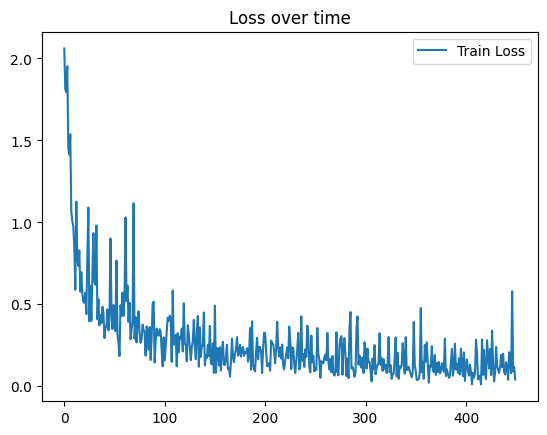

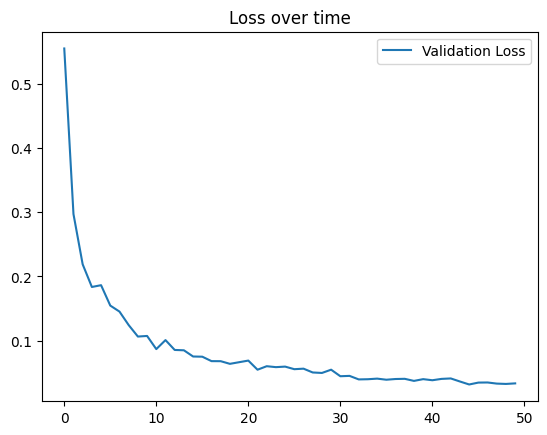

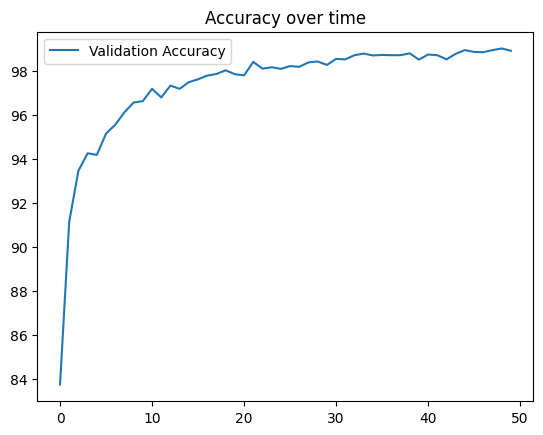

In [16]:
results_train = model.train_info()
train_loss = results_train['train_loss']
train_time = results_train['train_time']

results_validation = model.validation_info()
validation_loss = results_validation['validation_loss']
validation_acc = results_validation['validation_acc']

plt.plot(range(len(train_loss)), train_loss, label='Train Loss')

plt.legend()
plt.title('Loss over time')

plt.show()

plt.plot(range(len(validation_loss)), validation_loss, label='Validation Loss')

plt.legend()
plt.title('Loss over time')

plt.show()

x = range(len(validation_acc))
y = validation_acc

plt.plot(x, y, label='Validation Accuracy')

plt.legend()
plt.title('Accuracy over time')

plt.show()

In [17]:
import os, json, torch, random, numpy as np, matplotlib.pyplot as plt

In [18]:
def evaluate_agent(agent, data_load, device, mode = False):

    agent.eval()

    elements = 0
    csamp = 0
    tloss = 0

    with torch.no_grad():
        for data, target in data_load:

            elements += len(data)
            data = data.to(device)
            target = target.to(device)

            state = env.get_state(data)

            if mode == "agent":
              action = model.agent.select_action(state)
            elif mode == "random":
              action = model.env.action_space.sample()
            else:
              action = torch.tensor([1 for i in range(len(model.env.action_space.sample()))], dtype = torch.float)

            ViTnet.set_patches(action)

            output = functional.log_softmax(agent(data), dim=1)
            loss = functional.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            tloss += loss.item()
            csamp += pred.eq(target).sum()

    loss_val = tloss / elements
    acc_val = (100.0 * csamp / elements).cpu()

    print('\nAverage validation loss: ' + '{:.4f}'.format(loss_val) +
          '  Accuracy:' + '{:5}'.format(csamp) + '/' +
          '{:5}'.format(elements) + ' (' +
          '{:4.2f}'.format(acc_val) + '%)\n')

    return loss_val, acc_val

In [19]:
def visualize_patch_mask_hard(dataloader, patch_log_dir="results/patch_logs_mnist", num_samples=4, img_size=28,
    patch_size=4, device="cuda"):

    classes = [str(i) for i in range(10)]   # MNIST 클래스명 0~9

    # 데이터 샘플 가져오기
    batch_data, batch_labels = next(iter(dataloader))
    indices = random.sample(range(len(batch_data)), num_samples)
    batch_data = batch_data[indices].to(device)
    batch_labels = batch_labels[indices]

    # JSON 로그 선택
    all_logs = sorted([f for f in os.listdir(patch_log_dir) if f.endswith(".json")])
    selected_logs = random.sample(all_logs, min(num_samples, len(all_logs)))

    fig, axes = plt.subplots(2, num_samples, figsize=(3 * num_samples, 6))

    for i, (img, label, log_file) in enumerate(zip(batch_data, batch_labels, selected_logs)):
        with open(os.path.join(patch_log_dir, log_file)) as f:
            patch_log = json.load(f)

        # patch_list 불러오기
        patch_list = np.array(patch_log["patch_list"], dtype=np.float32)

        patch_probs = patch_list

        n_patches = len(patch_probs)
        grid_size = int(np.sqrt(n_patches))

        hard_mask = (patch_probs > 0.5).astype(np.float32)
        hard_mask = hard_mask.reshape(grid_size, grid_size)

        # upsample mask → 이미지 크기와 맞추기
        mask = np.repeat(np.repeat(hard_mask, patch_size, axis=0), patch_size, axis=1)

        # MNIST: 1채널 → 2D를 3D로 확장
        img_np = img.squeeze(0).cpu().numpy()    # (28,28)
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        img_np = np.repeat(img_np[..., None], 3, axis=2)   # (28,28,3)

        masked_img = img_np * mask[..., None]

        # 원본
        axes[0, i].imshow(img_np, cmap="gray")
        axes[0, i].set_title(f"Label: {classes[label.item()]}")
        axes[0, i].axis("off")

        # 마스크
        axes[1, i].imshow(masked_img, cmap="gray")
        axes[1, i].set_title(f"Masked - {log_file}")
        axes[1, i].axis("off")

        print(f"{log_file} → probs range: {patch_probs.min():.3f} ~ {patch_probs.max():.3f}")

    plt.tight_layout()
    plt.show()


epoch049_batch0016.json → probs range: 0.000 ~ 1.000
epoch113_batch0102.json → probs range: 0.000 ~ 1.000
epoch001_batch0452.json → probs range: 0.000 ~ 1.000
epoch040_batch0138.json → probs range: 0.000 ~ 1.000
epoch049_batch0325.json → probs range: 0.000 ~ 1.000
epoch032_batch0283.json → probs range: 0.000 ~ 1.000


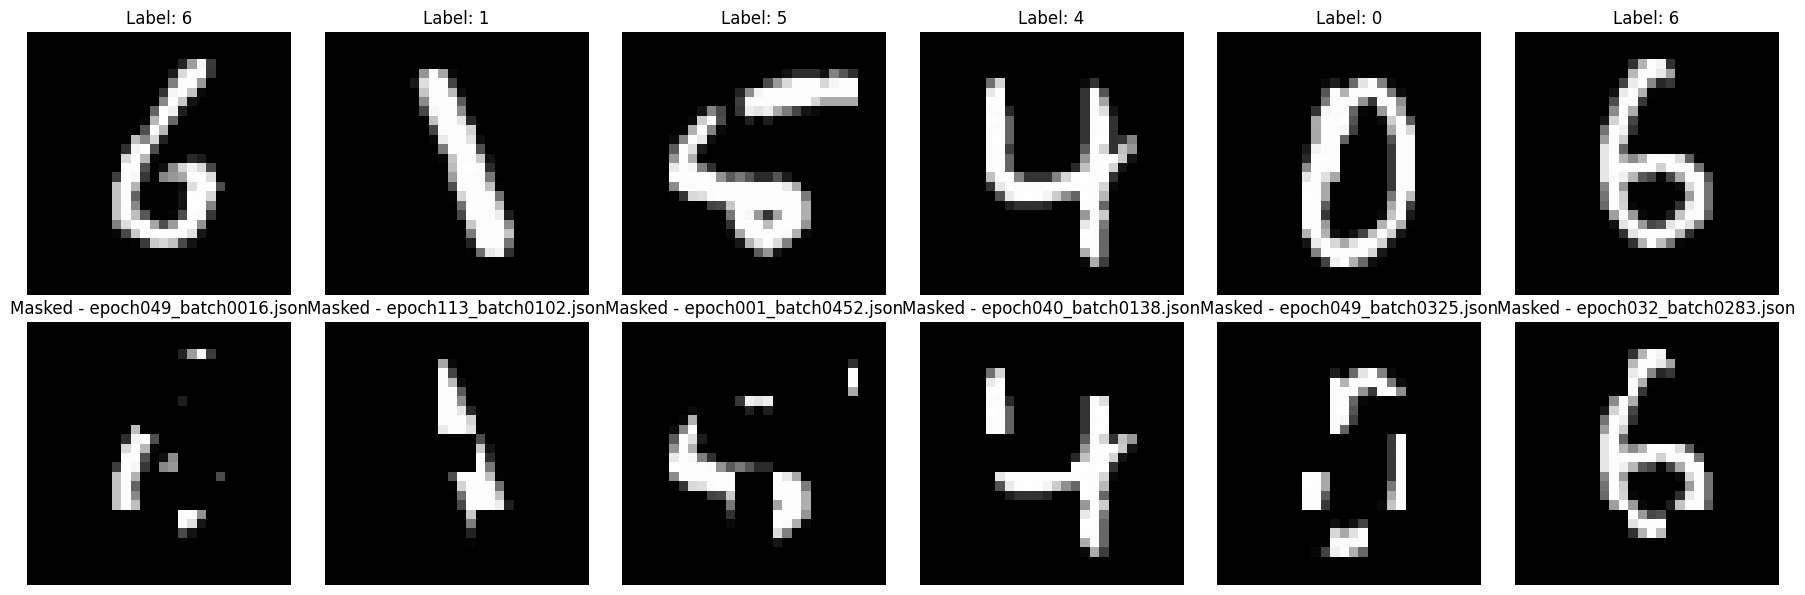

In [20]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 전처리 (normalize 포함)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))   # MNIST 공식값
])

val_dataset = datasets.MNIST(root="./Datasets_mnist", train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)


visualize_patch_mask_hard(
    dataloader=val_loader,
    patch_log_dir="results/patch_logs_mnist",
    num_samples=6,
    img_size=28,
    patch_size=4,
    device="cuda"
)


In [21]:
import torch 

print(torch.__version__)

import torch
from torch import nn
from torch import nn, einsum
import torch.nn.functional as F
from torch import optim

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np
import torchvision
import time
from torchinfo import summary

torch.manual_seed(42)


2.4.1+cu121


In [22]:
DOWNLOAD_PATH = '/data/mnist'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=True, download=True,
                                       transform=transform_mnist)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_mnist)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)


In [23]:
import matplotlib.pyplot as plt

# Function to show a batch of images
def show_batch(data_loader):
    batch = next(iter(data_loader))
    images, labels = batch
    grid = torchvision.utils.make_grid(images, nrow=10)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title("Batch of Training Images")
    plt.axis('off')
    plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


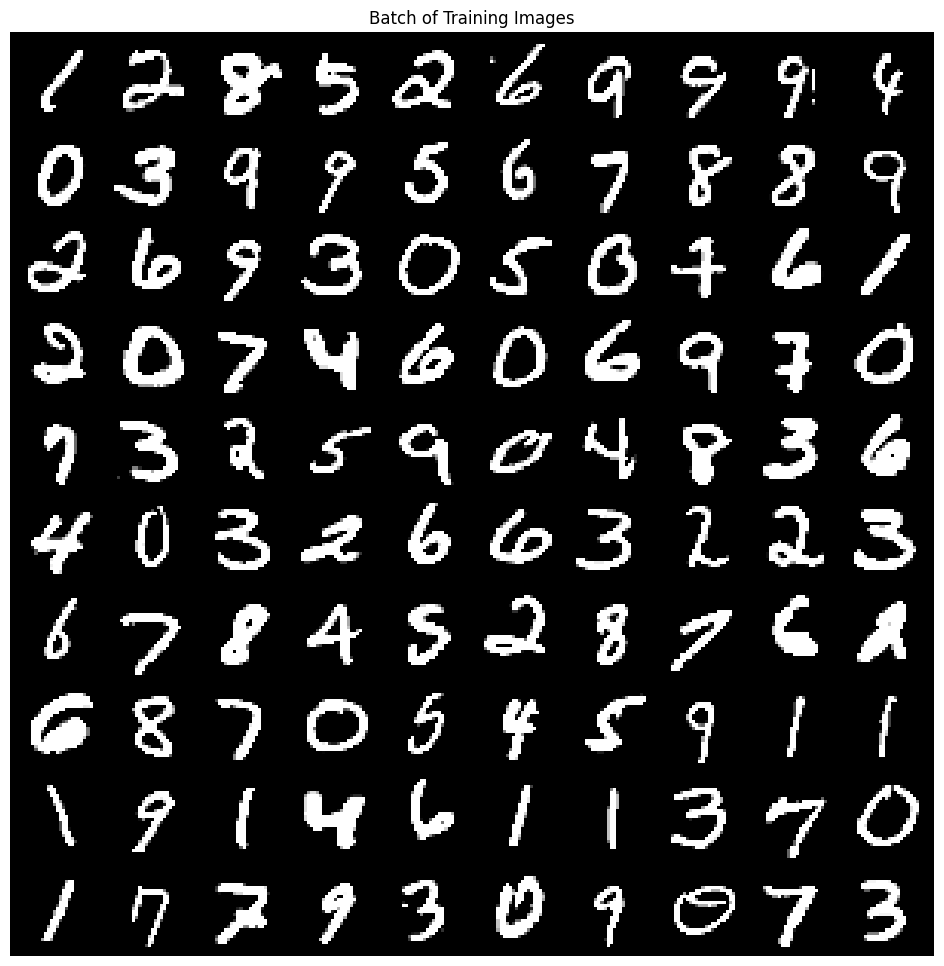

In [24]:
# Print images for validation
show_batch(train_loader)

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
device

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(), #nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


In [25]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)


In [26]:
model = ViT(image_size=28, patch_size=4, num_classes=10, channels=1, dim=64, depth=6, heads=4, mlp_dim=128)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)

summary(model)

Layer (type:depth-idx)                             Param #
ViT                                                3,264
├─Sequential: 1-1                                  --
│    └─Rearrange: 2-1                              --
│    └─Linear: 2-2                                 1,088
├─Dropout: 1-2                                     --
├─Transformer: 1-3                                 --
│    └─ModuleList: 2-3                             --
│    │    └─ModuleList: 3-1                        82,432
│    │    └─ModuleList: 3-2                        82,432
│    │    └─ModuleList: 3-3                        82,432
│    │    └─ModuleList: 3-4                        82,432
│    │    └─ModuleList: 3-5                        82,432
│    │    └─ModuleList: 3-6                        82,432
├─Identity: 1-4                                    --
├─Sequential: 1-5                                  --
│    └─LayerNorm: 2-4                              128
│    └─Linear: 2-5                            

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

499722


In [28]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    start_time = time.time()

    for i, (data, target) in enumerate(data_loader):
        batch_start = time.time()

        optimizer.zero_grad()
        output = F.log_softmax(model(data.to(device)), dim=1)
        loss = F.nll_loss(output, target.to(device))
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            batch_time = time.time() - batch_start
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  f' ({100 * i / len(data_loader):3.0f}%)]  Loss: {loss.item():6.4f}  Batch time: {batch_time:.4f}s')

        loss_history.append(loss.item())

    epoch_time = time.time() - start_time
    print(f"Epoch training time: {epoch_time:.2f} seconds")

    return epoch_time


In [29]:
def evaluate(model, data_loader, loss_history):
    model.eval()

    start_time = time.time()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = F.log_softmax(model(data.to(device)), dim=1)
            loss = F.nll_loss(output, target.to(device), reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target.to(device)).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    eval_time = time.time() - start_time

    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)')
    
    print(f"Evaluation time: {eval_time:.2f} seconds\n")

    return eval_time


In [30]:
N_EPOCHS = 50

start_time = time.time()


train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, test_loader, test_loss_history)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')


Epoch: 1
[    0/60000 (  0%)]  Loss: 2.4061  Batch time: 0.0279s
[10000/60000 ( 17%)]  Loss: 0.5019  Batch time: 0.0202s
[20000/60000 ( 33%)]  Loss: 0.2695  Batch time: 0.0216s
[30000/60000 ( 50%)]  Loss: 0.2921  Batch time: 0.0215s
[40000/60000 ( 67%)]  Loss: 0.3014  Batch time: 0.0230s
[50000/60000 ( 83%)]  Loss: 0.2756  Batch time: 0.0238s
Epoch training time: 26.07 seconds

Average test loss: 0.2013  Accuracy: 9355/10000 (93.55%)
Evaluation time: 1.91 seconds

Epoch: 2
[    0/60000 (  0%)]  Loss: 0.1726  Batch time: 0.0223s
[10000/60000 ( 17%)]  Loss: 0.1711  Batch time: 0.0240s
[20000/60000 ( 33%)]  Loss: 0.1594  Batch time: 0.0222s
[30000/60000 ( 50%)]  Loss: 0.1795  Batch time: 0.0234s
[40000/60000 ( 67%)]  Loss: 0.1358  Batch time: 0.0234s
[50000/60000 ( 83%)]  Loss: 0.2411  Batch time: 0.0208s
Epoch training time: 26.05 seconds

Average test loss: 0.1468  Accuracy: 9550/10000 (95.50%)
Evaluation time: 1.91 seconds

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.0675  Batch time: 0.015

In [31]:
evaluate(model, test_loader, test_loss_history)


Average test loss: 0.0781  Accuracy: 9811/10000 (98.11%)
Evaluation time: 1.89 seconds



1.885340690612793

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion matrix
def plot_confusion_matrix(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)

            output = model(data)
            _, preds = torch.max(output, dim=1)

            all_preds.extend(preds.cpu().numpy())   # CPU로 변환 후 numpy()
            all_labels.extend(target.numpy())        # target은 원래 CPU라 OK

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


In [33]:
def evaluate(model, data_loader, loss_history):
    model.eval()

    start_time = time.time()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = F.log_softmax(model(data.to(device)), dim=1)
            loss = F.nll_loss(output, target.to(device), reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target.to(device)).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    eval_time = time.time() - start_time

    accuracy = (100.0 * correct_samples / total_samples).item()

    print(f"\nAverage test loss: {avg_loss:.4f}  Accuracy: {accuracy:.2f}%")
    print(f"Evaluation time: {eval_time:.2f} seconds\n")

    return avg_loss, accuracy, eval_time


In [34]:
# train_times = []
# eval_times = []

# for epoch in range(1, N_EPOCHS + 1):
#     print('Epoch:', epoch)
#     t = train_epoch(model, optimizer, train_loader, train_loss_history)
#     e = evaluate(model, test_loader, test_loss_history)

#     train_times.append(t)
#     eval_times.append(e)

# print("Total training time:", sum(train_times))
# print("Total evaluation time:", sum(eval_times))


In [35]:
train_times = []
eval_times = []

for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)

    train_time = train_epoch(model, optimizer, train_loader, train_loss_history)

    avg_loss, accuracy, eval_time = evaluate(model, test_loader, test_loss_history)

    train_times.append(train_time)
    eval_times.append(eval_time)

print("Total training time:", sum(train_times))
print("Total evaluation time:", sum(eval_times))


Epoch: 1
[    0/60000 (  0%)]  Loss: 0.0379  Batch time: 0.0243s
[10000/60000 ( 17%)]  Loss: 0.0052  Batch time: 0.0228s
[20000/60000 ( 33%)]  Loss: 0.0413  Batch time: 0.0232s
[30000/60000 ( 50%)]  Loss: 0.0017  Batch time: 0.0235s
[40000/60000 ( 67%)]  Loss: 0.0405  Batch time: 0.0219s
[50000/60000 ( 83%)]  Loss: 0.0314  Batch time: 0.0225s
Epoch training time: 25.49 seconds

Average test loss: 0.0740  Accuracy: 98.18%
Evaluation time: 1.92 seconds

Epoch: 2
[    0/60000 (  0%)]  Loss: 0.0031  Batch time: 0.0226s
[10000/60000 ( 17%)]  Loss: 0.0032  Batch time: 0.0200s
[20000/60000 ( 33%)]  Loss: 0.0005  Batch time: 0.0199s
[30000/60000 ( 50%)]  Loss: 0.0021  Batch time: 0.0231s
[40000/60000 ( 67%)]  Loss: 0.0231  Batch time: 0.0223s
[50000/60000 ( 83%)]  Loss: 0.0006  Batch time: 0.0240s
Epoch training time: 25.59 seconds

Average test loss: 0.0674  Accuracy: 98.22%
Evaluation time: 1.90 seconds

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.0059  Batch time: 0.0227s
[10000/60000 ( 17%)]  L

In [36]:
vit_train_time = sum(train_times)
print("Total ViT train time:", vit_train_time)

Total ViT train time: 1351.1582028865814


In [37]:
# ViT-only 최종 Accuracy
vit_loss, vit_acc, vit_eval_time = evaluate(model, test_loader, test_loss_history)

# ViT-only FLOPs
vit_flops, vit_params = compute_flops(model)


Average test loss: 0.0684  Accuracy: 98.44%
Evaluation time: 1.93 seconds



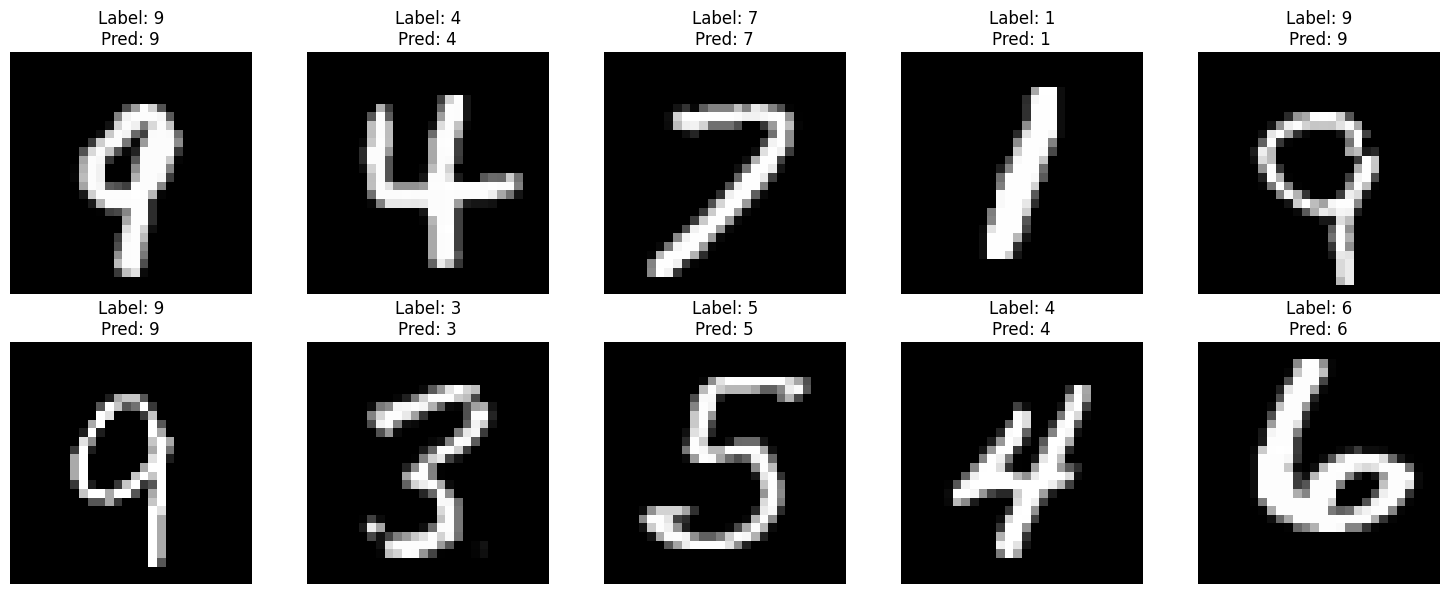

In [38]:
# Visualize correct and wrong predictions
def plot_predictions(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for data, target in data_loader:
            data_gpu = data.to(device)

            output = model(data_gpu)
            _, preds = torch.max(output, dim=1)

            all_preds.extend(preds.cpu().numpy())   # CPU로 변환 후 numpy()
            all_labels.extend(target.numpy())       # target은 CPU에 원래 있음
            all_images.extend(data.numpy())         # 시각화는 CPU 데이터 사용

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_images = np.array(all_images)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.imshow(all_images[i][0], cmap='gray')
        ax.set_title(f'Label: {all_labels[i]}\nPred: {all_preds[i]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_predictions(model, test_loader, device)


In [39]:
def save_results(model_name, acc, loss, train_time, eval_time, flops, params):
    return {
        "model_name": model_name,
        "accuracy": acc,
        "loss": loss,
        "train_time": train_time,
        "eval_time": eval_time,
        "flops": flops,
        "params": params
    }


In [40]:
from thop import profile

def compute_flops(model, img_size=28):
    dummy = torch.randn(1, 1, img_size, img_size).to(device)
    macs, params = profile(model, inputs=(dummy,), verbose=False)
    return macs, params


In [41]:
class RLViT_FLOPs(nn.Module):
    def __init__(self, vit_model, mask):
        super().__init__()
        self.vit = vit_model
        self.mask = mask

    def forward(self, x):
        # 1. 임베딩
        x = self.vit.to_patch_embedding(x)
        pe = posemb_sincos_2d(x).to(x.device)
        x = rearrange(x, 'b ... d -> b (...) d') + pe

        # 2. Mask 적용
        x = x[:, self.mask, :]

        # 3. Transformer 적용
        x = self.vit.transformer(x)

        # 4. 평균 풀링
        x = x.mean(dim=1)

        # 5. Classification head
        return self.vit.linear_head(x)


In [42]:
final_mask = torch.tensor(ViTnet.get_patches()).bool()

wrapper = RLViT_FLOPs(ViTnet, final_mask).to(device)
rl_flops, rl_params = compute_flops(wrapper)

In [43]:
# RL 학습 끝나고 mask 불러오기
final_mask = torch.tensor(ViTnet.get_patches()).bool()

# FLOPs 측정용 wrapper 모델 생성
wrapper = RLViT_FLOPs(ViTnet, final_mask).to(device)

rl_flops, rl_params = compute_flops(wrapper)

print("RL-ViT FLOPs:", rl_flops)
print("RL-ViT Params:", rl_params)


RL-ViT FLOPs: 102718464.0
RL-ViT Params: 3943082.0


In [44]:
def print_comparison(vit_res, rl_res):
    print("\n==================== RESULTS COMPARISON ====================")
    print(f"ViT Accuracy:      {vit_res['accuracy']:.2f}%")
    print(f"RL-ViT Accuracy:   {rl_res['accuracy']:.2f}%")

    print(f"ViT FLOPs:         {vit_res['flops']:,}")
    print(f"RL-ViT FLOPs:      {rl_res['flops']:,}")

    print(f"ViT Params:        {vit_res['params']:,}")
    print(f"RL-ViT Params:     {rl_res['params']:,}")

    print(f"Train Time (ViT):  {vit_res['train_time']:.2f}s")
    print(f"Train Time (RL):   {rl_res['train_time']:.2f}s")

    print(f"Speedup (FLOPs RL/ViT): {rl_res['flops'] / vit_res['flops']:.3f}x")
    print("============================================================")


In [45]:
def plot_accuracy_curves(vit_acc_list, rl_acc_list):
    plt.figure(figsize=(8,5))
    plt.plot(vit_acc_list, label="ViT Accuracy", linewidth=2)
    plt.plot(rl_acc_list, label="RL-ViT Accuracy", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()


In [46]:
def plot_loss_curves(vit_loss_list, rl_loss_list):
    plt.figure(figsize=(8,5))
    plt.plot(vit_loss_list, label="ViT Loss", linewidth=2)
    plt.plot(rl_loss_list, label="RL-ViT Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()


In [47]:
def plot_time_curves(vit_times, rl_times):
    plt.figure(figsize=(8,5))
    plt.plot(vit_times, label="ViT Train Time", linewidth=2)
    plt.plot(rl_times, label="RL-ViT Train Time", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Seconds")
    plt.title("Training Time per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()


In [48]:
def plot_flops_bar(vit_flops, rl_flops):
    plt.figure(figsize=(6,4))
    plt.bar(["ViT", "RL-ViT"], [vit_flops, rl_flops], color=["skyblue", "orange"])
    plt.ylabel("FLOPs")
    plt.title("FLOPs Comparison")
    plt.show()


In [49]:
def visualize_comparison(vit_res, rl_res,
                         vit_acc_list, rl_acc_list,
                         vit_loss_list, rl_loss_list,
                         vit_times, rl_times):

    print_comparison(vit_res, rl_res)

    plot_accuracy_curves(vit_acc_list, rl_acc_list)
    plot_loss_curves(vit_loss_list, rl_loss_list)
    plot_time_curves(vit_times, rl_times)
    plot_flops_bar(vit_res["flops"], rl_res["flops"])


In [50]:
vit_res = {
    "accuracy": vit_acc,
    "flops": vit_flops,
    "params": vit_params,
    "train_time": vit_train_time
}

rl_res = {
    "accuracy": rl_acc,
    "flops": rl_flops,
    "params": rl_params,
    "train_time": rl_train_time
}

print_comparison(vit_res, rl_res)


==================== RESULTS COMPARISON ====================
ViT Accuracy:      98.44%
RL-ViT Accuracy:   97.62%
ViT FLOPs:         24,959,472.0
RL-ViT FLOPs:      102,718,464.0
ViT Params:        496,458.0
RL-ViT Params:     3,943,082.0
Train Time (ViT):  1351.16s
Train Time (RL):   886.65s
Speedup (FLOPs RL/ViT): 4.115x
